In [ ]:
#Load data
from google.colab import drive
drive.mount('/content/gdrive')
filepath_train = 'gdrive/MyDrive/handsignimages/Train'
filepath_test = 'gdrive/My Drive/handsignimages/Test'

#Preprocess data by generating tensors representing each image and rescales pixel values to fractions. Split training data into 90/10 Train/Val sets.
from keras.preprocessing.image import ImageDataGenerator

Train_generator = ImageDataGenerator(rescale = 1/255, validation_split = 0.1)

#Apply preprocessing to Train and Test image sets. The function loads all images from folders by letter and categorizes them.
#All images are 28x28. Load in batches consistent with training process.
Train = Train_generator.flow_from_directory(filepath_train, target_size =(28, 28), class_mode ='categorical', batch_size = 1, subset='training')
Validation = Train_generator.flow_from_directory(filepath_train, target_size =(28, 28), class_mode ='categorical', batch_size = 1, subset='validation')

#Set class weights for later so that mini-batches are balanced.
from collections import Counter

counter = Counter(Train.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 24936 images belonging to 24 classes.
Found 2759 images belonging to 24 classes.


[[[[0.07450981 0.07450981 0.07450981]
   [0.20784315 0.20784315 0.20784315]
   [0.28235295 0.28235295 0.28235295]
   ...
   [0.5529412  0.5529412  0.5529412 ]
   [0.5529412  0.5529412  0.5529412 ]
   [0.5529412  0.5529412  0.5529412 ]]

  [[0.07843138 0.07843138 0.07843138]
   [0.21176472 0.21176472 0.21176472]
   [0.28235295 0.28235295 0.28235295]
   ...
   [0.56078434 0.56078434 0.56078434]
   [0.56078434 0.56078434 0.56078434]
   [0.56078434 0.56078434 0.56078434]]

  [[0.08627451 0.08627451 0.08627451]
   [0.21568629 0.21568629 0.21568629]
   [0.28627452 0.28627452 0.28627452]
   ...
   [0.57254905 0.57254905 0.57254905]
   [0.57254905 0.57254905 0.57254905]
   [0.57254905 0.57254905 0.57254905]]

  ...

  [[0.37647063 0.37647063 0.37647063]
   [0.37647063 0.37647063 0.37647063]
   [0.37647063 0.37647063 0.37647063]
   ...
   [0.36078432 0.36078432 0.36078432]
   [0.35686275 0.35686275 0.35686275]
   [0.3529412  0.3529412  0.3529412 ]]

  [[0.38823533 0.38823533 0.38823533]
   [0.3

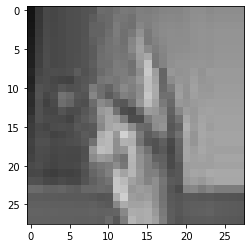

In [ ]:
import matplotlib.pyplot as plt

for _ in range(1):
    img, label = Train.next()
    print(img,label)
    plt.imshow(img[0])
    plt.show()

In [ ]:
#Create CNN structure
import math
from random import uniform
from tensorflow.keras.layers import BatchNormalization

dim_input = 28 #size of our images are 28x28
dim_filter = 3 #common kernel size is 3x3
dim_maxpool = 2 #common pooling size of 2x2
dim_batch = 32 #default batch size, will keep batch_size large enough for ~800 steps per epoch
num_epochs = 10 #reasonable number of epochs to train
num_steps = math.ceil(24936/dim_batch) #~800 steps per epoch leads to good gradient movement

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

#2 iterations of Convolution, Pooling works well
#Additional testing shows adding Dropout and Batch Normalization improves model
model = Sequential()

#First, run images through convolution layer, with padding, with common shape (input, input, 16), then MaxPool
#This will allow CNN to detect small differences between images 
model.add(Conv2D(16, (dim_filter,dim_filter), input_shape = (dim_input,dim_input,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (dim_maxpool, dim_maxpool), strides = 1))

#Next, run images through another convolution layer, without padding, with increased dimensionality (input, input, 32), then Normalize and MaxPool
#This will allow CNN to detect more complex differences between images
model.add(Conv2D(32, (dim_filter,dim_filter), input_shape = (dim_input,dim_input,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (dim_maxpool, dim_maxpool), strides = 2))

#We add one more layer with increased dimensionality, normalization, and maxpool without padding.
#This will help as previous iterations with 2 conv2d layers topped out at 85% accuracy.
model.add(Conv2D(64, (dim_filter,dim_filter), activation = 'relu', padding = 'valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (dim_maxpool, dim_maxpool), strides = 2))

#Add a Dropout layer to avoid overfitting problem seen in previous iterations
model.add(Dropout(uniform(0,1)))

model.add(Flatten()) #reduces dimensionality of tensor to fully connected layer
model.add(Dense(128, activation = 'relu')) #further reduces dimensionality of fully-connected layer
model.add(Dense(24, activation = 'softmax')) #brings output of fully-connected layer to size 24, same as our letters to be predicted

In [ ]:
metrics = ['accuracy']#, 'precision','recall']

#Utilize Adam optimizer which uses stochastic gradient descent with learning rate to 0.001. Set loss to cross entropy loss.
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = metrics)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 27, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 11, 11, 64)      

In [ ]:
#Run fit generator that displays performance by epoch, we want steps in validation to be similar to training.
#Use early stopping mechanism as validation loss seems to converge and then oscillate.
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)
history = model.fit_generator(Train, class_weight = class_weights, steps_per_epoch = num_steps, epochs = num_epochs, validation_data = Validation, validation_steps = math.ceil(2759/dim_batch), callbacks=[early_stop])

Epoch 1/10


<ipython-input-10-9139530f6220>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(Train, class_weight = class_weights, steps_per_epoch = num_steps, epochs = num_epochs, validation_data = Validation, validation_steps = math.ceil(2759/dim_batch), callbacks=[early_stop])


780/780 [==============================] - 4820s 6s/step - loss: 0.2580 - accuracy: 0.9369 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 2/10
780/780 [==============================] - 97s 125ms/step - loss: 0.0479 - accuracy: 0.9874 - val_loss: 0.0874 - val_accuracy: 0.9692
Epoch 3/10
780/780 [==============================] - 98s 125ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 2.6340e-04 - val_accuracy: 1.0000
Epoch 4/10
780/780 [==============================] - 100s 128ms/step - loss: 1.9804e-04 - accuracy: 1.0000 - val_loss: 1.3803e-04 - val_accuracy: 1.0000
Epoch 5/10
780/780 [==============================] - 97s 124ms/step - loss: 1.7454e-04 - accuracy: 1.0000 - val_loss: 1.3691e-04 - val_accuracy: 1.0000
Epoch 6/10
780/780 [==============================] - 97s 125ms/step - loss: 6.8154e-05 - accuracy: 1.0000 - val_loss: 6.8981e-05 - val_accuracy: 1.0000
Epoch 7/10
780/780 [==============================] - 96s 123ms/step - loss: 3.8800e-05 - accuracy: 1.0000 - val_

In [ ]:
#Load testing data
Test_generator = ImageDataGenerator(rescale = 1/255)
Test = Test_generator.flow_from_directory(filepath_test, target_size = (28, 28), batch_size = 1, class_mode ='categorical') #want to sample whole set for test

#Score model from previous step against training set
score = model.evaluate_generator(Test, steps = 7172)
for idx, metric in enumerate(model.metrics_names):
    print(metric, score[idx])

Found 7172 images belonging to 24 classes.


<ipython-input-11-07354ebf216c>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(Test, steps = 7172)


loss 0.16621941328048706
accuracy 0.9567763805389404


This CNN produces an accuracy of about 96%, which is much better than previous iterations.

Previous iterations had two Conv2d layers with MaxPool, which produced accuracy of 85% max. This is an interesting outcome, as even classification of simple 28x28 images benefits from deeper CNN architectures.

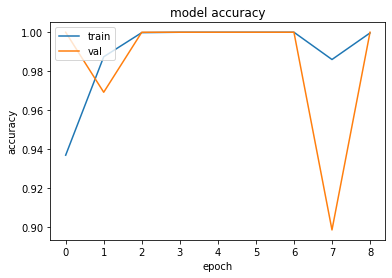

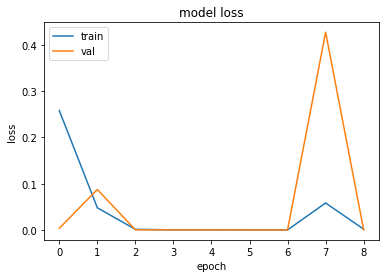

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Interstingly, early-stopping algorithm did not stop training epochs earlier around the 4th or 5th epoch. As such, we see a late spike in accuracy and loss, but this gets resolved in training at the final epoch.